In [19]:
%matplotlib inline
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import backward
from coolmom import SGD

import numpy as np
import pickle
import os
from sklearn.utils import shuffle
from tqdm import tqdm
import ipdb

import Utils.util as util

np.random.seed(0)
torch.manual_seed(999)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(999)
    torch.cuda.empty_cache()

In [20]:
# CRASH_fname = 'CRASH_FE_filtered_subsampled_fmriADJ.pkl'

# with open(CRASH_fname, 'rb') as handle:
#     F_t, adj_mx, adj_mx_idx, _input, _gt, coeffs, \
#     inv_mapping, region_assignment, nTrain, nValid, \
#     nTest, scaler_in, scaler_out = pickle.load(handle)
    
CRASH_fname = 'CRASH_Fonly.pkl'
with open(CRASH_fname, 'rb') as handle:
    F_t, adj_mx, adj_mx_idx, _input, _gt, nTrain, \
    nValid, nTest, scaler_in, scaler_out = pickle.load(handle)


### helper functions to test

In [3]:
def weighted_mse(preds, labels, null_val=np.nan):
    # assign more weights to further away points (preds:[16, 1, 10])
    num_t = preds.shape[2]
    wts = (torch.arange(num_t) + 1.0) / (torch.arange(num_t) + 1.0).sum()

    loss = (preds-labels)**2
    loss = torch.mean(loss, [0,1])

    wts = wts.to(loss.device)
    loss = loss * wts
    
    return torch.mean(loss)

def clipped_repulsion(preds):
    preds = abs(preds)
    
    preds[preds < 1e-3] = 1e-3
    loss = 1 / (abs(preds)**2)
    return torch.mean(loss)

## Testing temporal conv-deconv: only using one node's value across time

(11712, 1, 10) (11712, 1, 10)


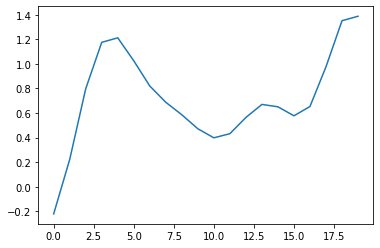

In [53]:
device = 'cuda:0'
# prep data
x = _input[...,0][:,None,:]
# y = x
y = _gt[...,0][:,None,:]
print(x.shape, y.shape)

# plt.plot(x[0,0])
# plt.plot(y[0,0])
plt.plot(np.concatenate((x[20,0],y[20,0]), 0))

x = torch.tensor(x).to(device)
y = torch.tensor(y).to(device)


In [63]:
def CausalConv1d(in_channels, out_channels, kernel_size, dilation=1, **kwargs):
    pad = (kernel_size - 1) * dilation
    return nn.Conv1d(in_channels, out_channels, kernel_size, padding=pad, dilation=dilation, **kwargs)

# def CausalConv1d(in_channels, out_channels, kernel_size, dilation=1, **kwargs): 
#     ## only pad left (??? pytorch doesn't support)
#     pad = (kernel_size - 1) * dilation
#     return nn.Conv1d(in_channels, out_channels, kernel_size, padding=(pad,0), dilation=dilation, **kwargs)


# tcn & de-tcn model
class tmodel(nn.Module): # for model testing, f in, same f out
    def __init__(self, device='cuda:0', dropout=0.3, in_dim=1,
                residual_channels=32, dilation_channels=32, skip_channels=256,
                end_channels=64, kernel_size=2, blocks=4, layers=2):
        super(tmodel, self).__init__()
        self.dropout = dropout
        self.blocks = blocks
        self.layers = layers
        self.device = device

        self.filter_convs = nn.ModuleList()
        self.gate_convs = nn.ModuleList()
        self.residual_convs = nn.ModuleList()
        self.skip_convs = nn.ModuleList()
        self.bn = nn.ModuleList()

        self.start_conv = nn.Conv1d(in_channels=in_dim,
                                    out_channels=residual_channels,
                                    kernel_size=1)

        receptive_field = 1
        multi_factor = 2
        for b in range(blocks):
            additional_scope = kernel_size - 1
            new_dilation = 1
            for i in range(layers):
                # dilated convolutions
                self.filter_convs.append(CausalConv1d(residual_channels, dilation_channels, kernel_size, new_dilation))
                self.gate_convs.append(CausalConv1d(residual_channels, dilation_channels, kernel_size, new_dilation))

                # 1x1 convolution for residual connection
                self.residual_convs.append(nn.Conv1d(in_channels=dilation_channels,out_channels=residual_channels,kernel_size=1))

                # 1x1 convolution for skip connection
                self.skip_convs.append(nn.Conv1d(in_channels=dilation_channels,out_channels=skip_channels,kernel_size=1))
                self.bn.append(nn.BatchNorm1d(residual_channels))

                new_dilation *= multi_factor
                receptive_field += additional_scope
                additional_scope *= multi_factor


#         ## temporal transConv (de-tcn)
#         convTransK = 2
#         convTransD = 1
#         upScale = 2

#         self.end_module_conv = nn.ModuleList()
#         self.end_module_up = nn.ModuleList()
#         # for b in range(blocks):
#         #     for l in range(layers):
#         for i in range(3):
#             self.end_module_up.append(nn.Upsample(scale_factor=upScale))
#             self.end_module_conv.append(nn.ConvTranspose1d(in_channels=skip_channels, out_channels=residual_channels, 
#                            kernel_size=convTransK, dilation=convTransD))
#         self.end_mlp = nn.Sequential(
#             nn.LeakyReLU(),
#             nn.Conv1d(in_channels=128, out_channels=16,
#                       kernel_size=1, bias=True),
#             nn.LeakyReLU(),
#             nn.Conv1d(in_channels=16, out_channels=1,
#                       kernel_size=1, bias=True)
#             )
        self.end_conv_1 = nn.Conv1d(skip_channels, end_channels, 1, bias=True)
        self.end_conv_2 = nn.Conv1d(end_channels, 10, 1, bias=True)
        self.end_conv_3 = nn.Conv1d(10, 1, 1, bias=True)
        
        self.receptive_field = receptive_field

    def forward(self, input, viz=False):
        # inputs: [batch_size, 1, in_len]
        ### deal with supports
        # print(self.receptive_field)
#         in_len = input.size(-1)
#         if in_len<self.receptive_field:
#             x = nn.functional.pad(input,(self.receptive_field-in_len,0))
#         else:
#             x = input
        x = input
        x = self.start_conv(x)

        if viz: # x.shape [16, 32, 15]
            ### plot features on different channels representing the same node fmri signal
            for j in range(x.shape[1]):
                plt.plot(x.detach().cpu().numpy()[0,j,:])
            plt.show()

        skip = 0

        # WaveNet layers
        for i in range(self.blocks * self.layers):
            # print(i, x.shape)
            #            |----------------------------------------|     *residual*
            #            |                                        |
            #            |    |-- conv -- tanh --|                |
            # -> dilate -|----|                  * ----|-- 1x1 -- + --> *input*
            #                 |-- conv -- sigm --|     |
            #                                         1x1
            #                                          |
            # ---------------------------------------> + -------------> *skip*

            #(dilation, init_dilation) = self.dilations[i]

            #residual = dilation_func(x, dilation, init_dilation, i)
            residual = x #[batch_size, residual_dim, 80, 16]

            # dilated convolution
            filter = self.filter_convs[i](residual)
            filter = torch.tanh(filter[:, :, :-self.filter_convs[i].padding[0]])
            gate = self.gate_convs[i](residual)
            gate = torch.sigmoid(gate[:, :, :-self.gate_convs[i].padding[0]])
            x = filter * gate
#             print(x.shape)
            if i % self.layers == self.layers-1:
                x = F.max_pool1d(x,2)
            # parametrized skip connection
            s = x
            s = self.skip_convs[i](s)
            try:
                if s.size(-1)*2 == skip.size(-1):
                    skip = F.max_pool1d(skip,2)
                else:
                    skip = skip[:, :,  -s.size(-1):]
            except:
                skip = 0
            skip = s + skip
            
            x = self.residual_convs[i](x)
            
#             print(residual.shape, x.shape)
            x = x + residual[:, :, -x.size(-1):]
            # x = torch.cat([x, residual[:, :, :, -x.size(3):], t_rep], axis=1)
            x = self.bn[i](x) # comment off for overfitting
            
        # del residual, x
        # skip: [batch_size, hidden_dim, num_nodes, 1]

        # ### test: adding noise to hidden rep
        # skip = skip + torch.normal(torch.zeros_like(skip), 0.1*skip.std()*torch.ones_like(skip))
        # ###
        # x = self.end_module(skip)
        # if viz: # x.shape [16, 512, 200, 1]
        #     # (results look similar) each node's h-D (h being #hidden dim) feature
        #     for j in range(10):
        #         plt.plot(x.detach().cpu().numpy()[0,:,j,0])
        #     plt.show()
        #     # plot each channel's value (on all nodes)
        #     for j in range(10): 
        #         plt.plot(x.detach().cpu().numpy()[0,j,:,0])
        #     plt.show()
        
        x = F.relu(skip)
        x = F.relu(self.end_conv_1(x))
#         x = self.end_conv_2(x).transpose(1,2)
        
        # output a single value
        x = F.relu(self.end_conv_2(x))   
        x = self.end_conv_3(x)
        
#         for i in range(3):#range(self.blocks * self.layers):       
#             x = self.end_module_up[i](x)
#             x = F.relu(self.end_module_conv[i](x))
        
#         x = self.end_mlp(x)
#         # x = self.end_mlp_f(x.transpose(1,3))
        return x

model = tmodel(blocks=3, layers=2).to(device)
print(model)
model_name = "garage/exp_t_pred1step_mse.pth" # for loading pretrained model and saving trained ones

tmodel(
  (filter_convs): ModuleList(
    (0): Conv1d(32, 32, kernel_size=(2,), stride=(1,), padding=(1,))
    (1): Conv1d(32, 32, kernel_size=(2,), stride=(1,), padding=(2,), dilation=(2,))
    (2): Conv1d(32, 32, kernel_size=(2,), stride=(1,), padding=(1,))
    (3): Conv1d(32, 32, kernel_size=(2,), stride=(1,), padding=(2,), dilation=(2,))
    (4): Conv1d(32, 32, kernel_size=(2,), stride=(1,), padding=(1,))
    (5): Conv1d(32, 32, kernel_size=(2,), stride=(1,), padding=(2,), dilation=(2,))
  )
  (gate_convs): ModuleList(
    (0): Conv1d(32, 32, kernel_size=(2,), stride=(1,), padding=(1,))
    (1): Conv1d(32, 32, kernel_size=(2,), stride=(1,), padding=(2,), dilation=(2,))
    (2): Conv1d(32, 32, kernel_size=(2,), stride=(1,), padding=(1,))
    (3): Conv1d(32, 32, kernel_size=(2,), stride=(1,), padding=(2,), dilation=(2,))
    (4): Conv1d(32, 32, kernel_size=(2,), stride=(1,), padding=(1,))
    (5): Conv1d(32, 32, kernel_size=(2,), stride=(1,), padding=(2,), dilation=(2,))
  )
  (resid

In [35]:
# load pretrained model
if os.path.isfile(model_name):
    # finetune
    pretrained_dict = torch.load(model_name)
    model_dict = model.state_dict()
    pretrained_dict = {k: v for k, v in pretrained_dict.items() if k in model_dict}
    model_dict.update(pretrained_dict) 
    model.load_state_dict(model_dict)

In [ ]:
# training & validation
lrate = 3e-4
wdecay = 4e-3 #TODO: increase
repulsion_w = 1e-4

num_epoch = 500
batch_size = 64

print(nTrain, nValid, nTest)
xTrain = x[:nTrain]
xValid = x[nTrain:nTrain+nValid]

yTrain = y[:nTrain]
yValid = y[nTrain:nTrain+nValid]

if not os.path.isfile(model_name):
    train_loss = []
    val_loss = []
min_val_loss = 1000
obj = nn.MSELoss()
for e in range(num_epoch):
#     if e%50 == 0 and e>0:
#         lrate = lrate * 0.8
#     optimizer = SGD(model.parameters(), lr=lrate, weight_decay=wdecay, momentum=0.9, beta=1e-2)
    optimizer = optim.Adam(model.parameters(), lr=lrate, weight_decay=wdecay)
    
    # train part
    model.train()
    # shuffle
    xTrain, yTrain = shuffle(xTrain, yTrain)
    cur_loss = []
    for i in tqdm(range(nTrain//batch_size)):
        batch_in = xTrain[i*batch_size:(i+1)*batch_size]
        batch_gt = yTrain[i*batch_size:(i+1)*batch_size][:,:,0:1]
        
        out = model(batch_in)
        loss = obj(out, batch_gt) #+ repulsion_w*clipped_repulsion(out)
        cur_loss.append(loss.item())
        
#         if i%150 == 0:
#             print(i, 'loss', loss.item(), 'mape', util.masked_mape(out, batch_gt,0).item())
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    train_loss.append(np.mean(cur_loss))
    print('epoch',e, 'train loss', np.mean(cur_loss))
    # validate each epoch
    model.eval()
    with torch.no_grad():
        out = model(xValid)
    loss = obj(out, yValid[:,:,0:1])
#     loss = obj(out, yValid) #+ repulsion_w*clipped_repulsion(out)
    val_loss.append(loss.item())
    if loss.item() < min_val_loss:
        min_val_loss = loss.item()
        torch.save(model.state_dict(), model_name)
    print('val loss', loss.item(), 'mape', util.masked_mape(out, yValid,0).item())


  5%|▍         | 6/128 [00:00<00:02, 49.60it/s]

8198 1757 1757


  5%|▍         | 6/128 [00:00<00:02, 50.27it/s]

epoch 0 train loss 0.22259659043629654
val loss 0.04391806200146675 mape 7.534990310668945


  4%|▍         | 5/128 [00:00<00:02, 48.14it/s]

epoch 1 train loss 0.041992416634457186
val loss 0.03197725489735603 mape 6.64809513092041


  4%|▍         | 5/128 [00:00<00:02, 48.99it/s]

epoch 2 train loss 0.027899412016267888
val loss 0.01817246899008751 mape 4.093479633331299


  4%|▍         | 5/128 [00:00<00:02, 48.75it/s]

epoch 3 train loss 0.021881205124373082
val loss 0.01716831512749195 mape 5.953685283660889


  4%|▍         | 5/128 [00:00<00:02, 49.81it/s]

epoch 4 train loss 0.016371133770007873
val loss 0.010182141326367855 mape 4.6591315269470215


  5%|▍         | 6/128 [00:00<00:02, 50.12it/s]

epoch 5 train loss 0.01627849612850696
val loss 0.008619369938969612 mape 4.580525875091553


  5%|▍         | 6/128 [00:00<00:02, 49.86it/s]

epoch 6 train loss 0.014232159624953056
val loss 0.007140600122511387 mape 4.816939830780029


  5%|▍         | 6/128 [00:00<00:02, 50.69it/s]

epoch 7 train loss 0.013881553284591064
val loss 0.014766297303140163 mape 3.3789565563201904


  4%|▍         | 5/128 [00:00<00:02, 49.80it/s]

epoch 8 train loss 0.013443953863315983
val loss 0.0072923991829156876 mape 4.677306652069092


  5%|▍         | 6/128 [00:00<00:02, 50.82it/s]

epoch 9 train loss 0.012843986833104282
val loss 0.008129803463816643 mape 3.937753915786743


  4%|▍         | 5/128 [00:00<00:02, 49.16it/s]

epoch 10 train loss 0.014039375600987114
val loss 0.0074213058687746525 mape 4.931251049041748


  4%|▍         | 5/128 [00:00<00:02, 49.55it/s]

epoch 11 train loss 0.011305797925160732
val loss 0.007039832882583141 mape 5.037226676940918


  8%|▊         | 10/128 [00:00<00:02, 49.40it/s]

min train loss 0.5071309765335172 min val loss 0.5126306414604187


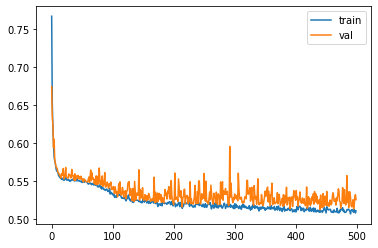

In [56]:
# plot loss curve
print('min train loss', min(train_loss), 'min val loss', min(val_loss))
plt.plot(train_loss, label='train')
plt.plot(val_loss, label='val')
plt.legend()
plt.show()

### Recursively predicting the next frame

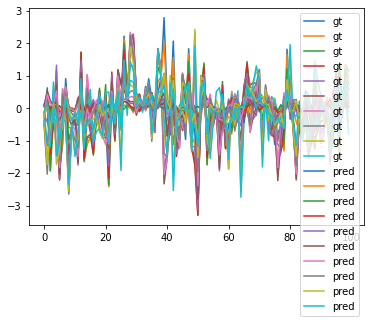

In [83]:
# test
yTest = y[-nTest:].squeeze()
xTest = x[-nTest:]
model.eval()
with torch.no_grad():
    test_out = model(xTest).detach().cpu().numpy().squeeze()

# plt.plot(yTest[:100].detach().cpu().numpy(), label='gt')
plt.plot(yTest[:,0:1][:100].detach().cpu().numpy(), label='gt')
plt.plot(test_out[:100], label='pred')
# plt.plot(xTest[:,0,-1][:100].detach().cpu().numpy().squeeze(), label='last input value')
plt.legend()

In [90]:
cur_in = xTest
pred = []

with torch.no_grad():
    for i in range(10):
        cur_out = model(cur_in)
        pred.append(cur_out)
        cur_in = torch.cat((cur_in, cur_out), 2)[:,:,1:]

pred = torch.cat(pred, 2).squeeze()
print(pred.shape, yTest.shape)
print('mape:', util.masked_mape(pred, yTest,0).item(), 'cc', util.get_cc(pred, yTest)[0])

i_num = 4
j_num = 5
plt.figure(figsize=(16,10))
for i in range(i_num):
    for j in range(j_num):
        k = i*j_num+j+1
#         print(k)
        plt.subplot(i_num, j_num, k)
        plt.plot(yTest[k].detach().cpu().numpy(), color='g')
        plt.plot(pred[k].detach().cpu().numpy(), color='r')
plt.show()

RuntimeError: Sizes of tensors must match except in dimension 1. Got 10 and 1 (The offending index is 0)

### observations
predict near future converges immediately, but predicting further-away frames need much more epochs

### Directly mapping / predicting t frames

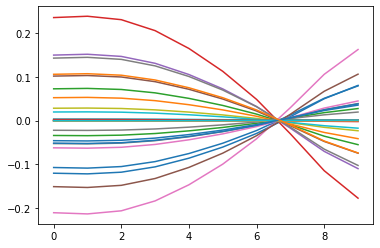

torch.Size([1757, 10]) torch.Size([1757, 10])
mape: 0.06740105897188187 cc 0.6453771691208389


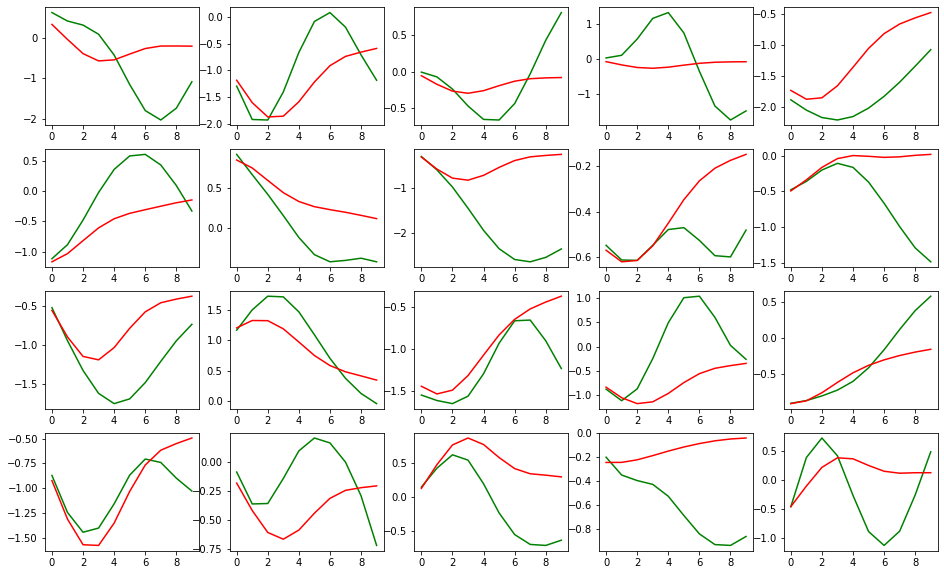

In [57]:
# test
yTest = y[-nTest:].squeeze()
xTest = x[-nTest:]

model.eval()
with torch.no_grad():
    test_out = model(xTest, viz=True).squeeze()

print(yTest.shape, test_out.shape)
print('mape:', util.masked_mape(test_out, yTest,0).item(), 'cc', util.get_cc(test_out, yTest)[0])

i_num = 4
j_num = 5
plt.figure(figsize=(16,10))
for i in range(i_num):
    for j in range(j_num):
        k = i*j_num+j+1
#         print(k)
        plt.subplot(i_num, j_num, k)
        plt.plot(yTest[k].detach().cpu().numpy(), color='g')
        plt.plot(test_out[k].detach().cpu().numpy(), color='r')
plt.show()

### Observations
Mapping is good.

prediction tend to converge to 0 --> this seems to happen to ARIMA as well (when predicting mean-stationary signals)

### t branches, each predict one future step. 
Also more weight on recent pred (otherwise further-away loss is dominating)

(Give up, since for the real problem EEG has so many frames, this isn't quite practical)